# Example: User Interaction With The Plot Window

The class |ClickEventHandler| allows for additional interaction with the plot
on top of that provided by ``matplotlib``.

Note: This may not work in Jupyter Notebook

To use the class, first import and process the data before:

In [1]:
import pathlib

import matplotlib.pyplot as plt

from pyms.GCMS.IO.JCAMP import JCAMP_reader
from pyms.IntensityMatrix import build_intensity_matrix
from pyms.Display import plot_ic, plot_peaks
from pyms.Noise.SavitzkyGolay import savitzky_golay
from pyms.TopHat import tophat
from pyms.BillerBiemann import BillerBiemann, rel_threshold, num_ions_threshold

In [2]:
data_directory = pathlib.Path(".").resolve().parent.parent / "pyms-data"
# Change this if the data files are stored in a different location

output_directory = pathlib.Path(".").resolve() / "output"

In [3]:
jcamp_file = data_directory / "gc01_0812_066.jdx"
data = JCAMP_reader(jcamp_file)
data.trim("500s", "2000s")
tic = data.tic
im = build_intensity_matrix(data)

 -> Reading JCAMP file '/home/vagrant/PyMassSpec/pyms-data/gc01_0812_066.jdx'
Trimming data to between 520 and 4517 scans


In [4]:
n_scan, n_mz = im.size

for ii in range(n_mz):
	ic = im.get_ic_at_index(ii)
	ic_smooth = savitzky_golay(ic)
	ic_bc = tophat(ic_smooth, struct="1.5m")
	im.set_ic_at_index(ii, ic_bc)

In [5]:
peak_list = BillerBiemann(im, points=9, scans=2)
pl = rel_threshold(peak_list, percent=2)
new_peak_list = num_ions_threshold(pl, n=3, cutoff=10000)

print("Number of filtered peaks: ", len(new_peak_list))


Number of filtered peaks:  72


Creating the plot proceeds much as before, except that 
|ClickEventHandler(peak_list=new_peak_list)| must be called before ``plt.show()``.

You should also assign this to a variable to prevent it being garbage collected.

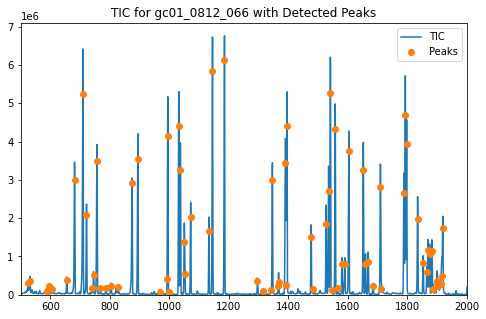

In [6]:
from pyms.Display import ClickEventHandler

%matplotlib inline
# Change to `notebook` for an interactive view

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot the TIC
plot_ic(ax, tic, label="TIC")

# Plot the peaks
plot_peaks(ax, new_peak_list)

# Set the title
ax.set_title('TIC for gc01_0812_066 with Detected Peaks')

# Set up the ClickEventHandler
handler = ClickEventHandler(new_peak_list)

# Add the legend
plt.legend()

plt.show()

Clicking on a Peak causes a list of the 5 highest intensity ions
at that Peak to be written to the terminal in order. The output should look
similar to this:


	RT: 1031.823
	Mass	 Intensity
	158.0	 2206317.857142857
	73.0	 628007.1428571426
	218.0	 492717.04761904746
	159.0	 316150.4285714285
	147.0	 196663.95238095228


If there is no Peak close to the point on the chart that was clicked, the
the following will be shown in the terminal:

	No Peak at this point


The |ClickEventHandler| class can be configured with a different tolerance, in
seconds, when clicking on a Peak, and to display a different number of top n
ions when a Peak is clicked.

In addition, clicking the right mouse button on a Peak displays the mass
spectrum at the peak in a new window.